<img src="./images/header.png">

***

# Utilizando dados Aleatórios

In [1]:
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm

from astroML.plotting.mcmc import plot_mcmc
from astroML.utils.decorators import pickle_results

[15.35191727 11.3663913  13.34746532 17.63267802 17.40029333 10.23830787
 17.84121711 16.56067403 18.49199749 21.09096828 20.29130348 23.16447457
 19.29785883 15.35597691 14.50173121 12.79864234 15.39223564  9.79577658
 11.10512278  7.49747301]


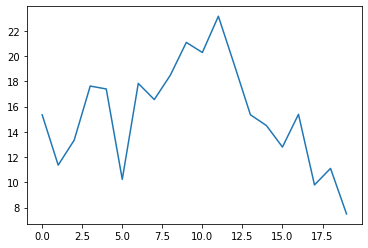

In [56]:
# ----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    mask = (t >= T)
    print(b0+mask)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y

def gauss(t, b0, A, ssig, T):
    y = A * np.exp(-(t - T)**2/2/ssig**2) + b0
    return y


def ssig(log_ssig):
    return np.exp(log_ssig)


np.random.seed(0)

N = 20
b0_true = 10
A_true = 10
ssig_true = 15.0
T_true = 50
sigma = 3.0

t = np.linspace(2, 98, N)

y_true = gauss(t, b0_true, A_true, ssig_true, T_true)
y_obs = np.random.normal(y_true, sigma)

plt.plot(y_obs)
print(y_obs)

In [42]:
# ----------------------------------------------------------------------
# Set up and run the MCMC sampling
# We need to wrap it in a function in order to be able to pickle the result
#@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(draws=3000, tune=10):
    with pm.Model():
        b0 = pm.Uniform('b0', 0, 50)
        A = pm.Uniform('A', 0, 50)
        T = pm.Uniform('T', 0, 100)
        #log_alpha = pm.Uniform('log_alpha', -10, 10)

        #y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T),
                      #sd=sigma, observed=x)
        log_ssig = pm.Uniform('log_ssig', -10, 10)

        y = pm.Normal('y', mu=gauss(t, b0, A, ssig(log_ssig), T),
                      sd=sigma, observed=y_obs)
        
        traces = pm.sample(draws=draws, tune=tune)

        return traces


traces = compute_MCMC_results()
mean_vals = pm.summary(traces)['mean']
mean_vals['ssig'] = ssig(mean_vals.pop('log_ssig'))

labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']

true = [b0_true, A_true, T_true, ssig_true]
limits = [(0.0, 19.0), (0, 19), (35, 64), (0.0, 59.0)]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_ssig, T, A, b0]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 12040/12040 [02:09<00:00, 93.08draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9973814539010101, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2432 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.021266645087276794, but should be close to 0.8. Try to increase the number of tuning steps.
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9694942772671058, but should be close to 0.8. Try to increase the number of tuning steps.
There were 948 divergenc

[10.05976023 10.16591968 10.41125137 10.90999842 11.79761936 13.17014151
 14.99095186 17.01474566 18.80165405 19.85917277 19.85917277 18.80165405
 17.01474566 14.99095186 13.17014151 11.79761936 10.90999842 10.41125137
 10.16591968 10.05976023]


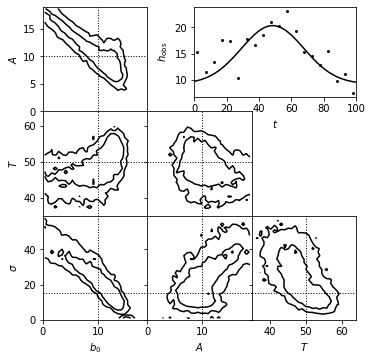

In [52]:
# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['b0', 'A', 'T']] + [ssig(traces['log_ssig'])],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = gauss(t_fit, **mean_vals)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k')

ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')



plt.show()

### Utilizando Ruído Browniano

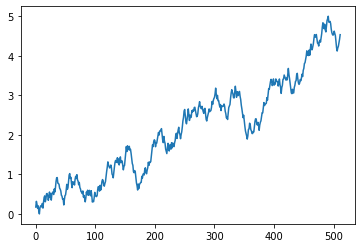

In [60]:
limitesuperior = 5.0
numeropontos = 512
 
temporario = np.random.uniform(low=-1, high=1, size=numeropontos)
saida = np.cumsum(temporario)
# normalizamos o sinal para ficar no limite especificado
max_value = max(saida)
min_value = min(saida)
 
for i in range(0, len(saida)):
    saida[i] = ((saida[i] - min_value) / (max_value - min_value)) * limitesuperior

    
y_obs = y_obs + saida    
plt.plot(saida)
plt.show()

In [45]:
# ----------------------------------------------------------------------
# Set up and run the MCMC sampling
# We need to wrap it in a function in order to be able to pickle the result
#@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(draws=3000, tune=1000):
    with pm.Model():
        b0 = pm.Uniform('b0', 0, 50)
        A = pm.Uniform('A', 0, 50)
        T = pm.Uniform('T', 0, 100)
        #log_alpha = pm.Uniform('log_alpha', -10, 10)

        #y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T),
                      #sd=sigma, observed=x)
        log_ssig = pm.Uniform('log_ssig', -10, 10)

        y = pm.Normal('y', mu=gauss(t, b0, A, ssig(log_ssig), T),
                      sd=sigma, observed=y_obs)
        
        traces = pm.sample(draws=draws, tune=tune)

        return traces


traces = compute_MCMC_results()
mean_vals = pm.summary(traces)['mean']
mean_vals['ssig'] = ssig(mean_vals.pop('log_ssig'))

labels = ['$b_0$', '$A$', '$T$', r'$\sigma$']

true = [b0_true, A_true, T_true, ssig_true]
limits = [(0.0, 19.0), (0, 19), (35, 64), (0.0, 59.0)]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_ssig, T, A, b0]
Sampling 4 chains: 100%|█████████████████████████████████████████████████████| 16000/16000 [00:17<00:00, 932.10draws/s]
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8856652760597279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875581735853914, but should be close to 0.8. Try to increase the number of tuning steps.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39972658781887854, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879811320832674, but should be close to 0.8. Tr

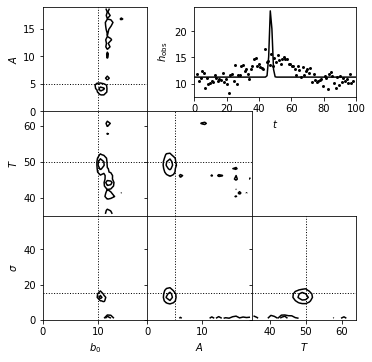

In [43]:
# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc([traces[i] for i in ['b0', 'A', 'T']] + [ssig(traces['log_ssig'])],
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = gauss(t_fit, **mean_vals)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k')

ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')



plt.show()